In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import json
import shlex

In [2]:
# Expresion regular
log_pattern = re.compile(r'''
    (?P<ip>\S+)  # IP del cliente
    \s
    (?P<identity>\S+) # Campo Identity
    \s
    (?P<user>\S+) # Campo User
    \s\[
    (?P<datetime>[^\]]+) # Fecha y hora
    \]\s\"
    (?P<request>[^\"]+) # Línea de petición
    \"\s
    (?P<status>\d{3}) # Código de estado
    \s
    (?P<size>\S+) # Tamaño de la respuesta
    \s\"
    (?P<referer>[^\"]+)\" # Referer
    \s\"
    (?P<user_agent>[^\"]+)\" # User-Agent
    \s\"?
    (?P<unknown>[^\"]*)\"? # Campo desconocido al final, ahora puede o no tener comillas
    ''', re.VERBOSE)

# Función para parsear una línea del log
def parse_log_line(line):
    """
    Parsea una línea del log y la convierte en un diccionario.

    Args:
        line (str): La línea del log a parsear.

    Returns:
        dict: Un diccionario con los campos de la línea del log, o None si la línea no se puede parsear.
    """
    match = log_pattern.match(line)
    if match:
        return match.groupdict()
    else:
        return None

In [3]:
# Leer el archivo línea por línea
log_data = []
with open("access_ok_aa.log", "r", encoding="utf-8") as f: # Especificamos encoding="utf-8"
    for line in f:
        parsed_line = parse_log_line(line)
        if parsed_line:
            log_data.append(parsed_line)

In [4]:
# Crear el DataFrame
logs = pd.DataFrame(log_data)

In [5]:
logs

,ip,identity,user,datetime,request,status,size,referer,user_agent,unknown
0,54.36.149.41,-,-,22/Jan/2019:03:56:14 +0330,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,-
1,31.56.96.51,-,-,22/Jan/2019:03:56:16 +0330,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-
2,31.56.96.51,-,-,22/Jan/2019:03:56:16 +0330,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-
3,40.77.167.129,-,-,22/Jan/2019:03:56:17 +0330,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,-
4,91.99.72.15,-,-,22/Jan/2019:03:56:17 +0330,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,-
...,...,...,...,...,...,...,...,...,...,...
1129035,66.249.66.91,-,-,22/Jan/2019:15:04:22 +0330,GET /static/css/font/wyekan/font.woff HTTP/1.1,304,0,-,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,-
1129036,83.123.130.107,-,-,22/Jan/2019:15:04:22 +0330,GET /image/27227?name=a4392114290d94c3d474bd6d...,200,12974,https://www.zanbil.ir/m/product/27227/%DA%AF%D...,Mozilla/5.0 (Android 6.0.1; Mobile; rv:63.0) G...,-
1129037,5.214.197.118,-,-,22/Jan/2019:15:04:22 +0330,GET /image/30/productType/120x90 HTTP/1.1,200,13906,https://www.zanbil.ir/m/product/31717/%D9%87%D...,Mozilla/5.0 (Linux; Android 4.4.2; LG-D802 Bui...,-
1129038,5.234.161.255,-,-,22/Jan/2019:15:04:22 +0330,GET /login/auth?login_error=1 HTTP/1.1,200,17194,https://www.zanbil.ir/login/auth,Mozilla/5.0 (Linux; Android 7.0; SM-A510F) App...,-


In [6]:
# Limpieza y Conversión de Tipos
logs['datetime'] = pd.to_datetime(logs['datetime'], format='%d/%b/%Y:%H:%M:%S %z')
logs['status'] = logs['status'].astype(int)
logs['size'] = logs['size'].replace('-', '0').astype(int)

In [7]:
# Extraer partes de la línea de petición
logs[["method", "url", "protocol"]] = logs["request"].str.split(" ", n=2, expand=True)

#### La siguiente celda agrega al dataframe una columna que muestra si el user agent pertenece a un bot

In [8]:
# Lista de user-agents de bots
bot_user_agents = [
    r"googlebot",
    r"bingbot",
    r"ahrefsbot",
    r"mj12bot",
    r"yandexbot",
    r"semrushbot",
    r"dotbot",
    r"exabot",
    r"applebot",
    r"uptimerobot",
    r"adsbot",
    r"facebookexternalhit",
    r"facebot",
    r"linkedinbot",
    r"twitterbot",
    r"slackbot",
    r"whatsapp",
    r"telegrambot",
    r"discordbot",
    r"pinterest",
    r"crawler",
    r"spider",
    r"bot[\/\- ]",  # Detecta patrones como "bot/" o "bot-" seguidos de un espacio o guion
    r"headless",  # Detecta navegadores headless (usados a menudo por bots)
    r"\bpython\b", # Detecta bots que usan python
]

# Función para detectar bots
def detect_bot(user_agent, bot_user_agents):
    """
    Detecta si un user-agent es un bot conocido.

    Args:
        user_agent (str): El user-agent a analizar.
        bot_user_agents (list): Una lista de patrones de user-agents de bots.

    Returns:
        bool: True si el user-agent es un bot conocido, False en caso contrario.
    """
    if user_agent is None:
        return False
    for bot_pattern in bot_user_agents:
        if re.search(bot_pattern, user_agent, re.IGNORECASE):
            return True
    return False

# Detección de bots
logs["is_bot"] = logs["user_agent"].apply(lambda x: detect_bot(x, bot_user_agents))

In [9]:
logs

,ip,identity,user,datetime,request,status,size,referer,user_agent,unknown,method,url,protocol,is_bot
0,54.36.149.41,-,-,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,-,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,HTTP/1.1,True
1,31.56.96.51,-,-,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-,GET,/image/60844/productModel/200x200,HTTP/1.1,False
2,31.56.96.51,-,-,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-,GET,/image/61474/productModel/200x200,HTTP/1.1,False
3,40.77.167.129,-,-,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,-,GET,/image/14925/productModel/100x100,HTTP/1.1,True
4,91.99.72.15,-,-,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,-,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,HTTP/1.1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129035,66.249.66.91,-,-,2019-01-22 15:04:22+03:30,GET /static/css/font/wyekan/font.woff HTTP/1.1,304,0,-,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,-,GET,/static/css/font/wyekan/font.woff,HTTP/1.1,True
1129036,83.123.130.107,-,-,2019-01-22 15:04:22+03:30,GET /image/27227?name=a4392114290d94c3d474bd6d...,200,12974,https://www.zanbil.ir/m/product/27227/%DA%AF%D...,Mozilla/5.0 (Android 6.0.1; Mobile; rv:63.0) G...,-,GET,/image/27227?name=a4392114290d94c3d474bd6d993a...,HTTP/1.1,False
1129037,5.214.197.118,-,-,2019-01-22 15:04:22+03:30,GET /image/30/productType/120x90 HTTP/1.1,200,13906,https://www.zanbil.ir/m/product/31717/%D9%87%D...,Mozilla/5.0 (Linux; Android 4.4.2; LG-D802 Bui...,-,GET,/image/30/productType/120x90,HTTP/1.1,False
1129038,5.234.161.255,-,-,2019-01-22 15:04:22+03:30,GET /login/auth?login_error=1 HTTP/1.1,200,17194,https://www.zanbil.ir/login/auth,Mozilla/5.0 (Linux; Android 7.0; SM-A510F) App...,-,GET,/login/auth?login_error=1,HTTP/1.1,False


### Análisis Exploratorio y Visualización

In [10]:
print(logs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129040 entries, 0 to 1129039
Data columns (total 14 columns):
 #   Column      Non-Null Count    Dtype                    
---  ------      --------------    -----                    
 0   ip          1129040 non-null  object                   
 1   identity    1129040 non-null  object                   
 2   user        1129040 non-null  object                   
 3   datetime    1129040 non-null  datetime64[ns, UTC+03:30]
 4   request     1129040 non-null  object                   
 5   status      1129040 non-null  int64                    
 6   size        1129040 non-null  int64                    
 7   referer     1129040 non-null  object                   
 8   user_agent  1129040 non-null  object                   
 9   unknown     1129040 non-null  object                   
 10  method      1129040 non-null  object                   
 11  url         1129037 non-null  object                   
 12  protocol    1129036 non-null

ip
66.249.66.194      34611
66.249.66.91       23225
91.99.30.32        16472
151.239.241.163    16274
66.249.66.92        7886
23.101.169.3        6955
91.99.72.15         5572
104.222.32.94       5001
40.77.167.170       4634
40.77.167.13        3823
Name: count, dtype: int64


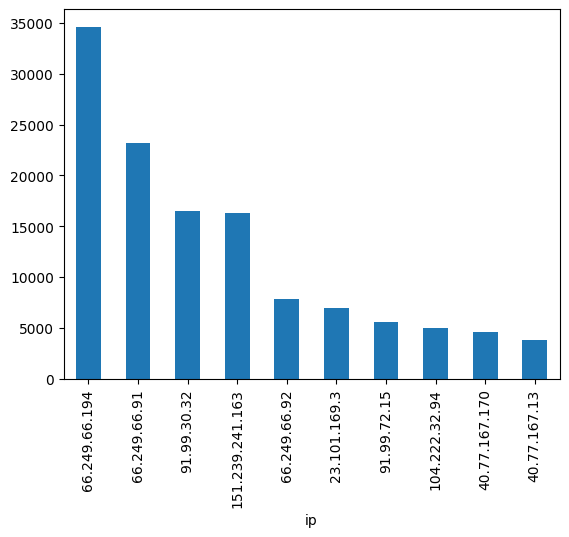

In [11]:
# 1. IPs más frecuentes
print(logs["ip"].value_counts().head(10))
logs["ip"].value_counts().head(10).plot(kind="bar")
plt.show()

status
200    1060003
304      23523
302      23009
404       9281
301       6463
499       5449
403        614
500        302
400        264
502         76
401         28
408         24
504          4
Name: count, dtype: int64


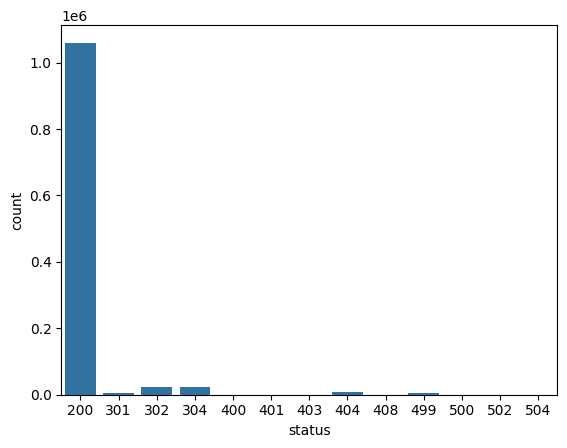

In [12]:
# 2. Códigos de estado
print(logs["status"].value_counts())
sns.countplot(x="status", data=logs)
plt.show()

url
/settings/logo                                31845
/static/css/font/wyekan/font.woff             25475
/site/alexaGooleAnalitic                      15786
/static/images/guarantees/warranty.png        10670
/static/images/guarantees/goodShopping.png     8415
/static/images/guarantees/bestPrice.png        8357
/static/images/guarantees/support.png          8270
/static/images/guarantees/fastDelivery.png     8269
/static/images/amp/instagram.png               7916
/static/images/amp/telegram.png                7826
Name: count, dtype: int64


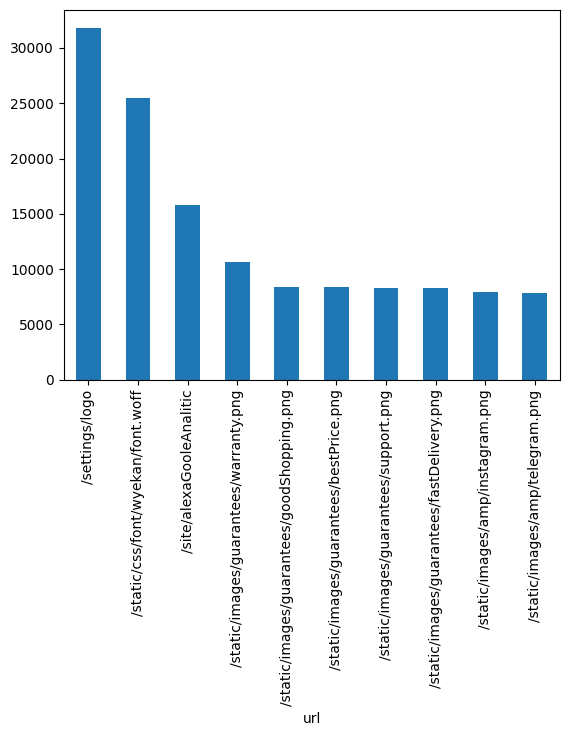

In [13]:
# 3. URLs más visitadas
print(logs["url"].value_counts().head(10))
logs["url"].value_counts().head(10).plot(kind="bar")
plt.show()

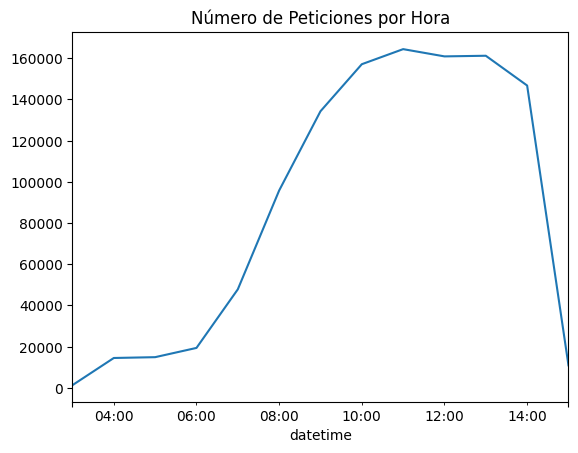

In [14]:
# 4. Tráfico por hora
logs.set_index("datetime")["ip"].resample("h").count().plot()
plt.title("Número de Peticiones por Hora")
plt.show()

user_agent
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                                                                                     113742
Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                                                                         105703
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                                                                         95030
Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20100101 Firefox/64.0                                                                                                                                          82118
Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0                                                                           

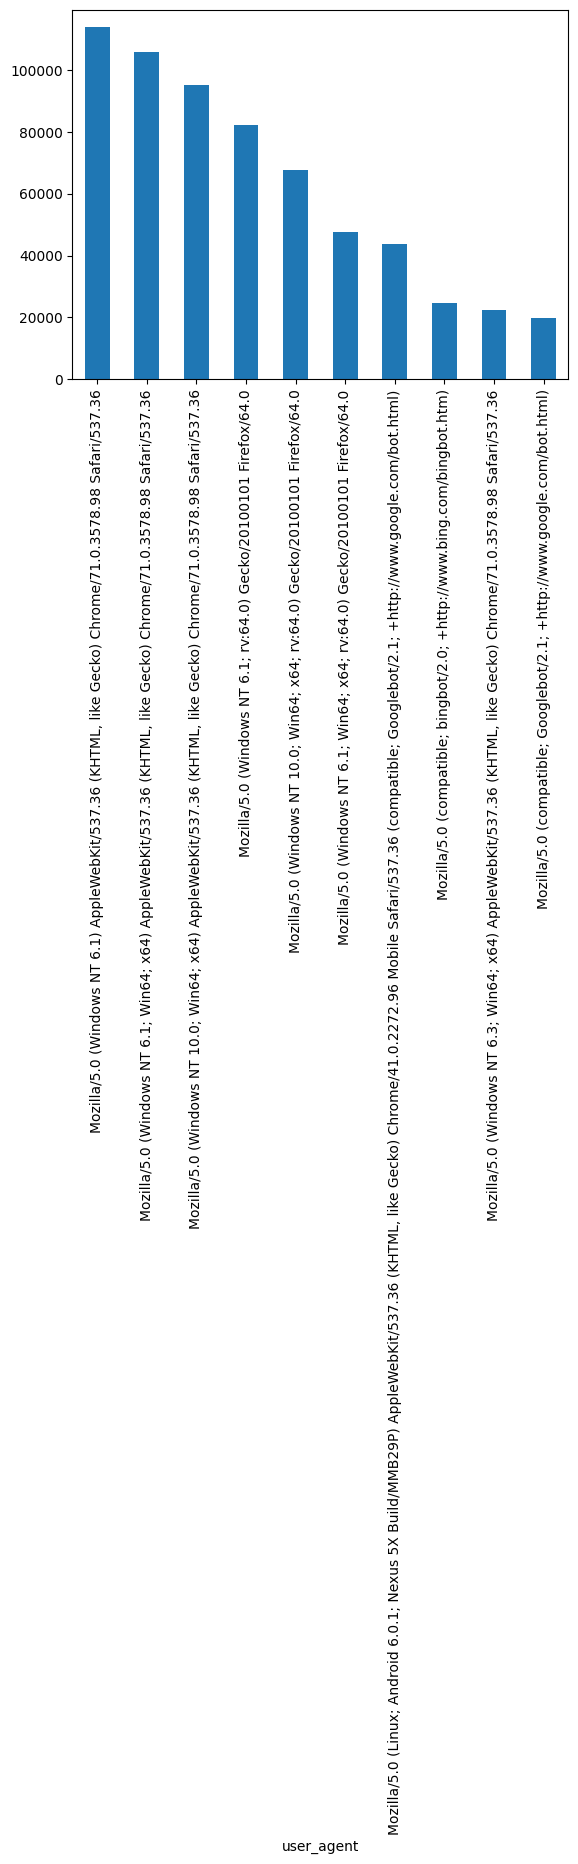

In [15]:
# 5. Top 10 User-Agents
print(logs["user_agent"].value_counts().head(10))
logs["user_agent"].value_counts().head(10).plot(kind="bar")
plt.show()

referer
-                                                                                                                          162136
https://www.zanbil.ir/                                                                                                      67113
https://znbl.ir/static/bundle-bundle_site_head.css                                                                          56356
https://www.zanbil.ir/browse/home-appliances/%D9%84%D9%88%D8%A7%D8%B2%D9%85-%D8%AE%D8%A7%D9%86%DA%AF%DB%8C                  34783
https://www.zanbil.ir/browse/digital-supplies/%D9%84%D9%88%D8%A7%D8%B2%D9%85-%D8%AF%DB%8C%D8%AC%DB%8C%D8%AA%D8%A7%D9%84     11029
https://www.zanbil.ir/browse/refrigerator-and-freezer/%DB%8C%D8%AE%DA%86%D8%A7%D9%84-%D9%81%D8%B1%DB%8C%D8%B2%D8%B1         10417
https://www.zanbil.ir/browse/cell-phone/%DA%AF%D9%88%D8%B4%DB%8C-%D9%85%D9%88%D8%A8%D8%A7%DB%8C%D9%84                        9632
https://www.zanbil.ir/filter/b1,p62                                               

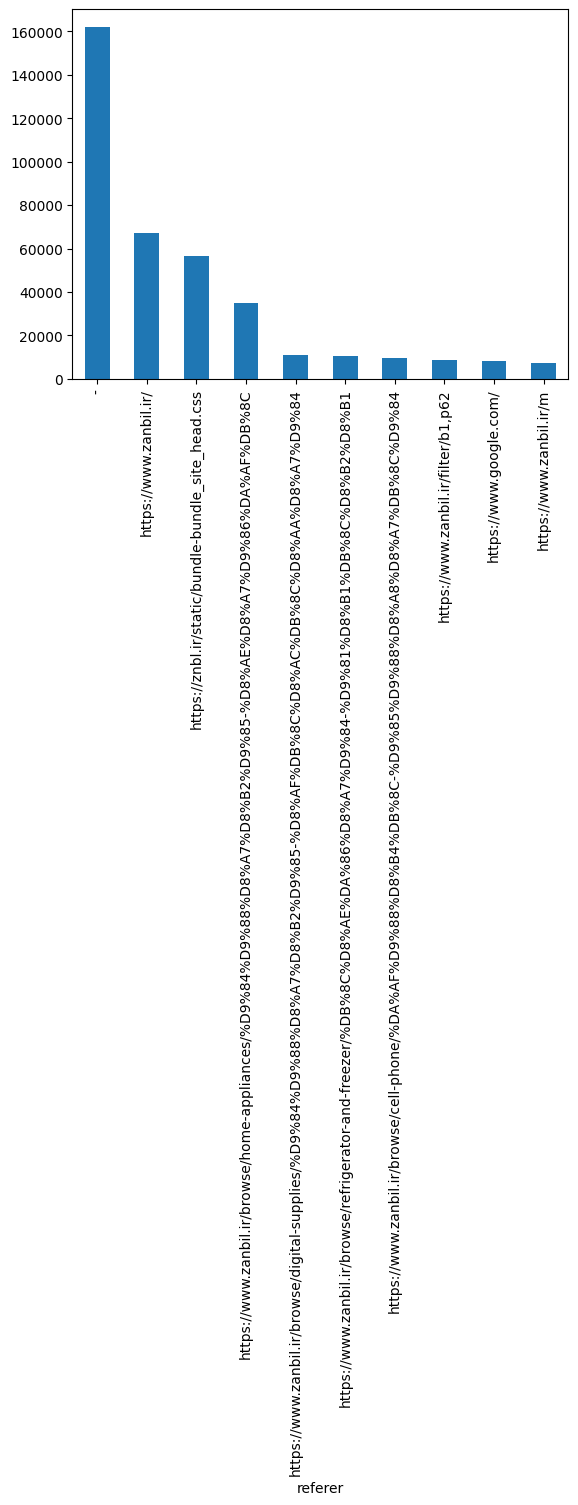

In [16]:
# 6. Top 10 Referers
print(logs["referer"].value_counts().head(10))
logs["referer"].value_counts().head(10).plot(kind="bar")
plt.show()

### Detección de Anomalías

In [17]:
# 7. Intentos de acceso fallidos (4xx, 5xx)
failed_requests = logs[(logs["status"] >= 400) & (logs["status"] < 600)]
print(failed_requests["url"].value_counts().head(10))

url
/apple-touch-icon-precomposed.png                                                        1344
/apple-touch-icon.png                                                                    1287
/apple-touch-icon-120x120-precomposed.png                                                1075
/apple-touch-icon-120x120.png                                                            1074
/                                                                                         299
/static/bundle-bundle_site_head.css                                                       179
/static/plugins/ckeditor-3.6.2.2/js/ckeditor/contents.min.css                             121
/static/images/third-party/footer.png                                                     108
/product/themes/default-rtl/style.css                                                      97
/browse/home-appliances/%D9%84%D9%88%D8%A7%D8%B2%D9%85-%D8%AE%D8%A7%D9%86%DA%AF%DB%8C      87
Name: count, dtype: int64


In [18]:
# 8. Picos de tráfico
hourly_requests = logs.set_index("datetime")["ip"].resample("h").count()
mean_requests = hourly_requests.mean()
std_requests = hourly_requests.std()
threshold = mean_requests + 1.1 * std_requests # Ajusta el multiplicador según sea necesario
anomalies = hourly_requests[hourly_requests > threshold]
print(anomalies)

datetime
2019-01-22 11:00:00+03:30    164407
Freq: h, Name: ip, dtype: int64


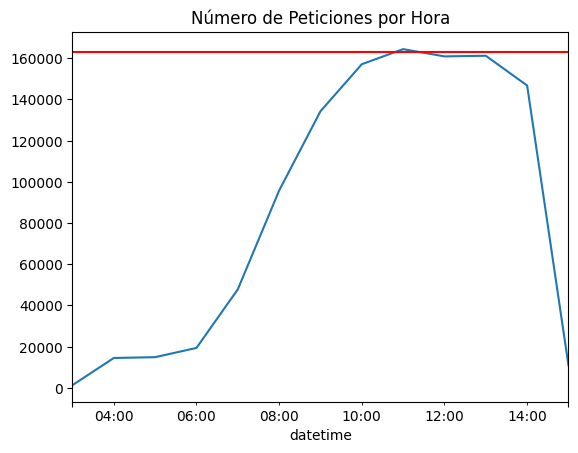

In [19]:
hourly_requests.plot()
plt.title("Número de Peticiones por Hora")
plt.axhline(y=threshold, color='r', linestyle='-')  # Dibuja una línea horizontal en el umbral
plt.show()

In [20]:
# 9. Bots detectados en User-Agent
# Filtrar los registros de bots
bot_logs = logs[logs["is_bot"]]
# Análisis de los bots
print(bot_logs["user_agent"].value_counts())

user_agent
Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.96 Mobile Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)    43609
Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)                                                                                                                                   24725
Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)                                                                                                                                  19734
Mozilla/5.0 (compatible; AhrefsBot/6.1; +http://ahrefs.com/robot/)                                                                                                                                         6529
Googlebot-Image/1.0                                                                                                                                          

In [21]:
# 10. Análisis del campo desconocido
print(logs["unknown"].value_counts().head(10))

unknown
-                 1126674
51.38.89.157          464
5.120.175.61          207
5.123.210.42          145
151.234.34.189         93
2.178.127.71           86
5.125.67.194           83
5.113.246.108          75
5.235.199.183          65
5.116.116.63           56
Name: count, dtype: int64


In [22]:
# 1. Filtrar por códigos de estado de error
failed_attempts = logs[logs["status"].isin([401, 403, 404, 500])]

# 2. Agrupar por IP y ventana de tiempo (ej. 1 minutos)
attempts_by_ip_time = failed_attempts.groupby([pd.Grouper(key="datetime", freq="1min"), "ip"])["status"].count().reset_index(name="count")

# 3. Establecer un umbral
threshold = 20

# 4. Filtrar IPs que superen el umbral
suspicious_ips = attempts_by_ip_time[attempts_by_ip_time["count"] > threshold]

print("Posibles ataques de fuerza bruta detectados:")
print(suspicious_ips)

Posibles ataques de fuerza bruta detectados:
                      datetime              ip  count
36   2019-01-22 04:10:00+03:30   31.184.130.52     27
1220 2019-01-22 10:13:00+03:30   5.134.151.184     28
1860 2019-01-22 11:35:00+03:30  206.189.97.112     21


In [23]:
#Función para obtener geolocalizacion
def get_geolocation(ip_address):
    """
    Obtiene la geolocalización de una IP usando freegeoip.app.

    Args:
        ip_address (str): La dirección IP a geolocalizar.

    Returns:
        dict: Un diccionario con la información de geolocalización, o None si hay un error.
    """
    try:
        response = subprocess.run(
            ["curl", f"https://freegeoip.app/json/{ip_address}"],
            capture_output=True,
            text=True,
            timeout=10,
        )
        response.check_returncode()  # Lanza una excepción si el código de retorno no es 0
        return json.loads(response.stdout)
    except subprocess.CalledProcessError as e:
        print(f"Error al obtener la geolocalización de {ip_address}: {e}")
        return None
    except subprocess.TimeoutExpired:
        print(f"Error: Tiempo de espera agotado al obtener la geolocalización de {ip_address}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error al decodificar la respuesta JSON de {ip_address}: {e}")
        return None

In [24]:
# Función para obtener la información whois de una IP.
def get_whois(ip_address):
    """
    Obtiene la información whois de una IP de forma segura.

    Args:
        ip_address (str): La dirección IP para la que se obtendrá la información whois.

    Returns:
        str: La información whois de la IP, o None si hay un error.
    """
    try:
        # Utilizar shlex.quote para sanitizar la entrada
        response = subprocess.run(
            ["whois", shlex.quote(ip_address)], capture_output=True, text=True, timeout=10
        )
        response.check_returncode()
        return response.stdout
    except subprocess.CalledProcessError as e:
        print(f"Error al obtener la información whois de {ip_address}: {e}")
        return None
    except subprocess.TimeoutExpired:
        print(f"Error: Tiempo de espera agotado al obtener la información whois de {ip_address}")
        return None

In [25]:
#Funcion para investigar una IP
def investigate_ip(ip, logs):
    """
    Investiga una IP sospechosa: geolocalización, whois y URLs accedidas.

    Args:
        ip (str): La dirección IP a investigar.
        logs (pd.DataFrame): El DataFrame de logs completo.
    """
    print(f"\n########################################")
    print(f"Investigando IP: {ip}")
    print(f"########################################")

    # Obtener geolocalización
    geolocation = get_geolocation(ip)
    if geolocation:
        print("\nGeolocalización:")
        for key, value in geolocation.items():
            print(f"{key}: {value}")

    # Obtener whois
    whois_info = get_whois(ip)
    if whois_info:
        print("\nInformación Whois:")
        print(whois_info)

    # URLs accedidas
    print(f"\nURLs sospechosas accedidas por la IP {ip}:")
    suspicious_urls = logs[(logs["ip"] == ip) & (logs["suspicious_url"])]["url"].value_counts()
    for url, count in suspicious_urls.items():
        print(f"{url}: {count} veces")

In [26]:
# Funcion para analizar IPs sospechosas
def analyze_suspicious_ips(suspicious_ips, logs):
    """
    Investiga las IPs sospechosas y las URLs a las que accedieron.

    Args:
        suspicious_ips (pd.DataFrame): Un DataFrame con las IPs sospechosas.
        logs (pd.DataFrame): El DataFrame completo de logs.
    """
    for index, row in suspicious_ips.iterrows():
        ip = row["ip"]
        investigate_ip(ip, logs)

In [27]:
# 2. Patrones sospechosos de URLs (lista de ejemplo, amplíala según tus necesidades)
suspicious_patterns = [
    "/admin", "/wp-admin", "/login", "config", ".php?id=",
    "' OR '1'='1", ".sql", ".asp",
    "phpinfo.php", "upload.php", ".cgi", ".old", ".bak", ".zip", ".tar.gz"
]

In [28]:
# 3. Función para detectar patrones sospechosos
def detect_suspicious_urls(url):
    """
    Detecta si una URL coincide con patrones sospechosos de escaneo de vulnerabilidades.

    Args:
        url (str): La URL a analizar.

    Returns:
        bool: True si la URL es sospechosa, False en caso contrario.
    """
    if url is None:
        return False
    for pattern in suspicious_patterns:
        if pattern.lower() in url.lower():
            return True
    return False

logs["url"] = logs["url"].fillna("")

In [29]:
# 4. Aplicar la función a las URLs
logs["suspicious_url"] = logs["url"].apply(detect_suspicious_urls)

In [30]:
# 5. Filtrar logs con URLs sospechosas
suspicious_logs = logs[logs["suspicious_url"]]

In [31]:
# 6. Agrupar por IP y contar URLs únicas (totales y sospechosas)
ip_url_counts = logs.groupby("ip").agg(
    total_unique_urls=("url", "nunique"),
    suspicious_unique_urls=("suspicious_url", "sum") # Cuenta True como 1, False como 0
).reset_index()

In [32]:
#7 Contar total de urls
total_urls_by_ip = logs.groupby("ip")["url"].count().reset_index(name="total_urls")
ip_url_counts = pd.merge(ip_url_counts, total_urls_by_ip, on="ip")

In [33]:
# 7. Calcular el porcentaje de URLs sospechosas
ip_url_counts["suspicious_percentage"] = (ip_url_counts["suspicious_unique_urls"] / ip_url_counts["total_unique_urls"]) * 100

In [34]:
# 8. Establecer umbrales
unique_url_threshold = 50  # Número mínimo de URLs únicas
suspicious_percentage_threshold = 10  # Porcentaje mínimo de URLs sospechosas

In [35]:
# 9. Filtrar IPs que superen los umbrales
suspicious_ips = ip_url_counts[
    (ip_url_counts["total_unique_urls"] > unique_url_threshold) &
    (ip_url_counts["suspicious_percentage"] > suspicious_percentage_threshold)
]

In [36]:
print("Posibles escaneos de vulnerabilidades detectados:")
print(suspicious_ips)

Posibles escaneos de vulnerabilidades detectados:
                  ip  total_unique_urls  suspicious_unique_urls  total_urls  \
2956    185.30.7.254                 92                      11         169   
5141     2.181.62.74                108                      27         220   
10808   5.114.130.71                 57                      30         141   
16143  5.200.127.113                 88                       9         163   
23404  89.196.114.94                 66                      11         135   
23493  89.196.22.196                 72                      10         125   
23548   89.196.66.66                 64                      10         138   

       suspicious_percentage  
2956               11.956522  
5141               25.000000  
10808              52.631579  
16143              10.227273  
23404              16.666667  
23493              13.888889  
23548              15.625000  


In [37]:
# Llamar a la función con las IPs sospechosas y el DataFrame de logs
analyze_suspicious_ips(suspicious_ips, logs)


########################################
Investigando IP: 185.30.7.254
########################################
Error al decodificar la respuesta JSON de 185.30.7.254: Expecting value: line 1 column 1 (char 0)

Información Whois:
% This is the RIPE Database query service.
% The objects are in RPSL format.
%
% The RIPE Database is subject to Terms and Conditions.
% See https://docs.db.ripe.net/terms-conditions.html

% Note: this output has been filtered.
%       To receive output for a database update, use the "-B" flag.

% Information related to '185.30.6.0 - 185.30.7.255'

% Abuse contact for '185.30.6.0 - 185.30.7.255' is 'm_ali_yousefi@yahoo.com'

inetnum:        185.30.6.0 - 185.30.7.255
netname:        GHAVAMINBANK-WAN
descr:          GHAVAMIN ASSIGNED BLOCK
country:        IR
admin-c:        GR8006-RIPE
tech-c:         GR8006-RIPE
status:         ASSIGNED PA
mnt-by:         MNT-GVM
created:        2013-07-03T18:22:15Z
last-modified:  2013-07-03T18:22:15Z
source:         RIPE

ro

Error al decodificar la respuesta JSON de 89.196.114.94: Expecting value: line 1 column 1 (char 0)

Información Whois:
% This is the RIPE Database query service.
% The objects are in RPSL format.
%
% The RIPE Database is subject to Terms and Conditions.
% See https://docs.db.ripe.net/terms-conditions.html

% Note: this output has been filtered.
%       To receive output for a database update, use the "-B" flag.

% Information related to '89.196.0.0 - 89.196.127.255'

% Abuse contact for '89.196.0.0 - 89.196.127.255' is 'abuse@mci.ir'

inetnum:        89.196.0.0 - 89.196.127.255
netname:        MCCI
descr:          Mobile Communication Company of Iran
country:        IR
admin-c:        RL7844-RIPE
tech-c:         RL7844-RIPE
status:         ASSIGNED PA
mnt-by:         MCCI-MNT
created:        2014-06-02T03:36:54Z
last-modified:  2018-02-24T11:27:18Z
source:         RIPE

person:         MohammadReza Hoznian
address:        Hamrah Tower - Kordestan High way cross Vanak st.Tehran Iran
pho